# What is this?



In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from pathlib import Path

In [2]:
def combine_configuration_results_to_df(path):
    dfs = []
    for csv_file in Path(path).glob("*.csv"):
        stem = csv_file.stem
        _, computer, os, python_version = stem.split("_")
        python_version = python_version.replace("python", "")
        
        df = pd.read_csv(csv_file, usecols=("Min", "Max", "Average", "Duration", "Energy consumption"))
        df.rename(columns={"Min": "P_min", "Max": "P_max", "Average": "P_mean", "Duration": "t_run", "Energy consumption": "E"}, inplace=True)

        df["Computer"] = computer
        df["OS"] = os
        df["Python_version"] = python_version

        dfs.append(df)

    return pd.concat(dfs, axis=0, ignore_index=True)


df = combine_configuration_results_to_df("results")
df

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version
0,2.17208,4.61929,2.75407,291.520,802.86692,RPi4B,FreeBSD,3.12
1,2.17860,4.33274,2.75425,290.893,801.19187,RPi4B,FreeBSD,3.12
2,2.17015,4.29701,2.75501,281.854,776.51185,RPi4B,FreeBSD,3.12
3,2.17166,4.34122,2.75492,282.026,776.96013,RPi4B,FreeBSD,3.12
4,2.17207,4.16131,2.75386,290.961,801.26496,RPi4B,FreeBSD,3.12
...,...,...,...,...,...,...,...,...
395,1.95921,3.35414,2.33557,1248.579,2916.14263,RPi3B+,Alpine,3.10
396,1.95587,3.30313,2.33507,1248.970,2916.43470,RPi3B+,Alpine,3.10
397,1.95763,3.38293,2.33552,1248.023,2914.78164,RPi3B+,Alpine,3.10
398,1.96758,3.30020,2.33456,1248.337,2914.31565,RPi3B+,Alpine,3.10


In [3]:
df.to_csv("/tmp/analysis.csv", index=False)

In [4]:
df.t_run = pd.to_timedelta(df.t_run, unit="s")

In [20]:
df.t_run

0     0 days 00:04:51.520000
1     0 days 00:04:50.893000
2     0 days 00:04:41.854000
3     0 days 00:04:42.026000
4     0 days 00:04:50.961000
               ...          
395   0 days 00:20:48.579000
396   0 days 00:20:48.970000
397   0 days 00:20:48.023000
398   0 days 00:20:48.337000
399   0 days 00:20:47.077000
Name: t_run, Length: 400, dtype: timedelta64[ns]

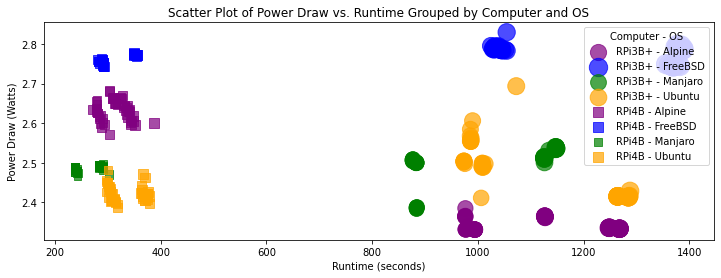

In [5]:
df['t_run_seconds'] = df['t_run'].dt.total_seconds()
grouped_df = df.groupby(['Computer', 'OS'])

# Define markers and colors
markers = {'RPi3B+': 'o', 'RPi4B': 's'}
palette = {'FreeBSD': 'blue', 'Manjaro': 'green', 'Ubuntu': 'orange', 'Alpine': 'purple'}

# Create the scatter plot
plt.figure(figsize=(12, 4))

for (computer, os), group in grouped_df:
    plt.scatter(group['t_run_seconds'], 
                group['P_mean'], 
                label=f'{computer} - {os}', 
                marker=markers[computer], 
                color=palette[os], 
                s=group.E / 10, alpha=0.7)
    
    y_data = group['P_mean']
    x_data = group['t_run_seconds']
    x_q1, x_median, x_q3 = np.percentile(x_data, [25, 50, 75])
    y_q1, y_median, y_q3 = np.percentile(y_data, [25, 50, 75])
    #plt.boxplot(y_data, positions=[x_median], widths=x_q3 - x_q1,
    #            showbox=True, manage_ticks=False)
    #plt.boxplot(x_data, positions=[y_median], vert=False,
    #            showbox=True, manage_ticks=False)
    #plt.gca().add_patch(plt.Rectangle((x_q1, y_q1), x_q3 - x_q1, y_q3 - y_q1,
    #                                  edgecolor='black'))
    
plt.xlabel('Runtime (seconds)')
plt.ylabel('Power Draw (Watts)')
plt.title('Scatter Plot of Power Draw vs. Runtime Grouped by Computer and OS')
plt.legend(title='Computer - OS')
plt.show()

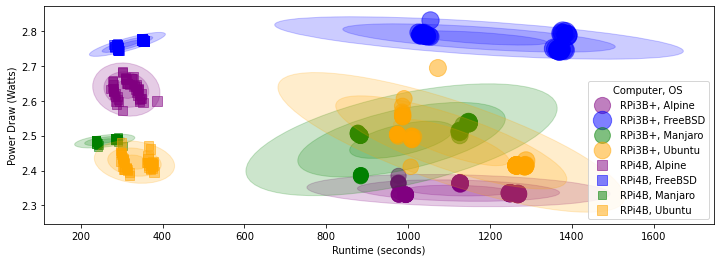

In [103]:
df["t_run_seconds"] = df["t_run"].dt.total_seconds()

grouped_df = df.groupby(["Computer", "OS"])

markers = {"RPi3B+": "o", "RPi4B": "s"}
palette = {"FreeBSD": "blue", "Manjaro": "green", "Ubuntu": "orange", "Alpine": "purple"}

def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(xy=position,
                                 width=nsig * width,
                                 height=nsig * height,
                                 angle=angle,
                                 **kwargs))

plt.figure(figsize=(12, 4))

for (computer, os), group in grouped_df:
    plt.scatter(group["t_run_seconds"], 
                group["P_mean"],
                label=f"{computer}, {os}",
                marker=markers[computer],
                color=palette[os],
                s=group.E / 10, alpha=0.5)

    cov = np.cov(group["t_run_seconds"], group["P_mean"])
    mean = [group["t_run_seconds"].mean(), group["P_mean"].mean()]

    draw_ellipse(mean, cov, plt.gca(),
                 edgecolor=palette[os],
                 facecolor=palette[os],
                 alpha=0.2)

plt.xlabel("Runtime (seconds)")
plt.ylabel("Power Draw (Watts)")
#plt.title("Bagplot of Power Draw vs. Runtime Grouped by Computer and OS")
plt.legend(title="Computer, OS")
plt.savefig("report_source/images/P_t_E_bagplot.pdf", bbox_inches="tight")
plt.show()


In [110]:
df[df.Computer == "RPi3B+"].t_run_seconds.describe()

count     200.000000
mean     1096.041265
std       155.793118
min       876.027000
25%       984.180000
50%      1042.143500
75%      1253.093750
max      1388.549000
Name: t_run_seconds, dtype: float64

In [111]:
df[df.Computer == "RPi4B"].t_run_seconds.describe()

count    200.000000
mean     303.954615
std       39.659607
min      237.130000
25%      283.862500
50%      297.505000
75%      338.595250
max      386.519000
Name: t_run_seconds, dtype: float64

In [117]:
df[df.t_run == df.t_run.min()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
69,1.56607,4.02517,2.48866,0 days 00:03:57.130000,590.13487,RPi4B,Manjaro,3.11,237.13


In [118]:
df[df.t_run == df.t_run.max()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
39,2.36925,3.65813,2.78762,0 days 00:23:08.549000,3870.74478,RPi3B+,FreeBSD,3.10,1388.549


In [114]:
df[df.P_mean == df.P_mean.max()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
47,2.36342,3.95478,2.82978,0 days 00:17:34.322000,2983.49772,RPi3B+,FreeBSD,3.13,1054.322


In [119]:
df[df.P_mean == df.P_mean.min()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
280,1.95567,3.30943,2.32994,0 days 00:16:33.778000,2315.44484,RPi3B+,Alpine,3.11,993.778


In [116]:
df.P_mean.describe()

count    400.000000
mean       2.549033
std        0.152123
min        2.329940
25%        2.419840
50%        2.500585
75%        2.705672
max        2.829780
Name: P_mean, dtype: float64

In [124]:
df[df.Computer == "RPi3B+"].E.describe()

count     200.000000
mean     2768.108704
std       459.245096
min      2106.120020
25%      2401.196435
50%      2866.209665
75%      2955.146102
max      3870.744780
Name: E, dtype: float64

In [123]:
df[df.Computer == "RPi4B"].E.describe()

count     200.000000
mean      783.407843
std       113.145325
min       589.260810
25%       724.876775
50%       774.543220
75%       883.103482
max      1004.874850
Name: E, dtype: float64

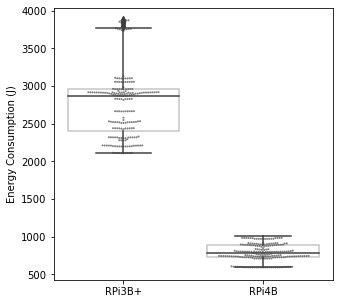

In [98]:
plt.figure(figsize=(5, 5))

df2 = df.sort_values("Computer")
p1 = sns.boxplot(data=df2, x="Computer", y="E", boxprops={"facecolor": "None", "alpha": 0.3})
p2 = sns.swarmplot(data=df2, x="Computer", y="E", zorder=.5, s=2, color="gray")

plt.xlabel("")
plt.ylabel('Energy Consumption (J)')
#plt.title('Energy Consumption by Computer')

plt.savefig("report_source/images/E_per_SUT.pdf", bbox_inches="tight")
plt.show()

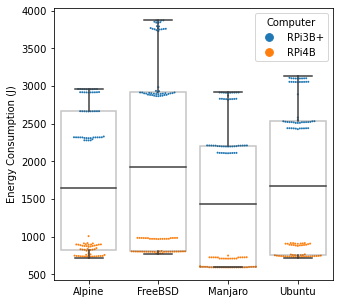

In [99]:
df2 = df.sort_values("OS")

plt.figure(figsize=(5, 5))

p1 = sns.boxplot(data=df2, x="OS", y="E", boxprops={"facecolor": "None", "alpha": 0.3})
p2 = sns.swarmplot(data=df2, x="OS", y="E", hue="Computer", zorder=.5, s=2)

plt.xlabel("")
plt.ylabel('Energy Consumption (J)')
#plt.title('Energy Consumption by Operating System')

plt.savefig("report_source/images/E_per_OS.pdf", bbox_inches="tight")
plt.show()

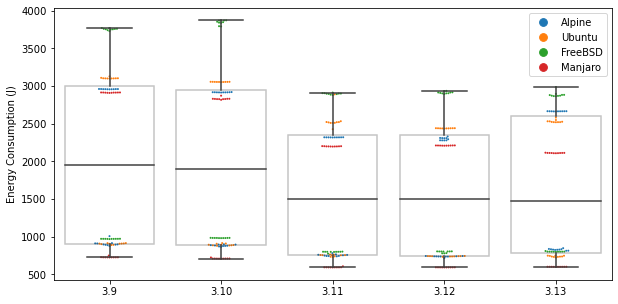

In [101]:
df2["minor_version"] = df.Python_version.apply(lambda v: int(v.split(".")[-1]))
df2 = df2.sort_values("minor_version")

plt.figure(figsize=(10, 5))

p1 = sns.boxplot(data=df2, x="Python_version", y="E", boxprops={"facecolor": "None", "alpha": 0.3})
p2 = sns.swarmplot(data=df2, x="Python_version", y="E", hue="OS", zorder=.5, s=2)

plt.xlabel("")
plt.ylabel('Energy Consumption (J)')
#plt.title('Energy Consumption by Computer')
plt.legend(loc="upper right")

plt.savefig("report_source/images/E_per_Python_version.pdf", bbox_inches="tight")
plt.show()